In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pandas

In [ ]:

import pyproj
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import datetime
import geopandas as gpd
from shapely.geometry import Point
import math
import warnings
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from scipy.interpolate import interp1d

# Configurar para visualización de Plotly en Google Colab
import plotly.io as pio
pio.renderers.default = 'colab'

# Tratamiento dataset solar - Creación variables temporales

Intentaremos crear variables temporales para poder unificar posteriormente los datasets de los terremotos y el del sol. Para ello, lo haremos con ayuda de las horas totales, ya que en ambos casos cada registro contendrá la información necesaria de lo que ocurre en cada hora, tanto en nuestras variables solares como de la cantidad de terremotos ocurridas durante cada hora.

In [ ]:
# Ruta de la carpeta actual en Google Drive
path = '/content/drive/My Drive/Master ciencia de datos (Big Data & TFM)/TFM - tormentas solares/bases de datos - nuevo'

# Ruta al archivo CSV en Google Drive
file_path = path + '/ACE_SWEPAM_Data_Hour.txt'

In [ ]:
# Cargar el archivo en un DataFrame, considerando la primera fila como encabezados
df = pd.read_csv(file_path, delim_whitespace=True, header=0)

In [ ]:
df.head()

,year,day,hr,proton_density,proton_temp,He4toprotons,proton_speed
0,1998,23,0,-9999.9,-9999.9,-9999.9004,-9999.9
1,1998,23,1,-9999.9,-9999.9,-9999.9004,-9999.9
2,1998,23,2,-9999.9,-9999.9,-9999.9004,-9999.9
3,1998,23,3,-9999.9,-9999.9,-9999.9004,-9999.9
4,1998,23,4,-9999.9,-9999.9,-9999.9004,-9999.9


In [ ]:
df.tail()

,year,day,hr,proton_density,proton_temp,He4toprotons,proton_speed
204763,2021,153,19,-9999.9,16174.0,-9999.9004,290.50
204764,2021,153,20,-9999.9,13833.0,-9999.9004,288.13
204765,2021,153,21,-9999.9,12628.0,-9999.9004,287.20
204766,2021,153,22,-9999.9,15514.0,-9999.9004,290.23
204767,2021,153,23,-9999.9,18407.0,-9999.9004,304.18


In [ ]:
# Función para obtener el mes y día a partir del día del año
def obtener_mes_dia(data):

  any = list(data["year"])
  dia = list(data["day"])
  fecha = []

  for y in any:

    dias = list(data["day"][data["year"]==y])

    dias_mes = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

    es_bisiesto = (y % 4 == 0 and (y % 100 != 0 or y % 400 == 0))

    if es_bisiesto:
        dias_mes[1] = 29

    meses = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

    contador = 1

    for d in dias:

      if (d <= (sum(dias_mes[0:contador]))):
        fecha.append(f"{y}-{meses[contador-1]}-{d-sum(dias_mes[0:contador-1])}")
      else:
        contador = contador + 1
        fecha.append(f"{y}-{meses[contador-1]}-{d-sum(dias_mes[0:contador-1])}")

  return fecha

La función de arriba la he dejado estar, mejor voy a tratar esta parte del código en excel

In [ ]:
#df.to_excel(path+'/dataframes_preprocesados/sol_dias_totales_python.xlsx', index=False)

# Sol - Inspección Visual y Valores outliers

Lo de crear variables temporales para tratarlo con horas totales (similar a *hora_total*, aquí llamado *HORA TOTAL*) lo he hecho en excel, el resultado es tal como se ve en la vista .head() a continuación.

In [ ]:
# Ruta de la carpeta actual en Google Drive
path = '/content/drive/My Drive/Master ciencia de datos (Big Data & TFM)/TFM - tormentas solares/bases de datos - nuevo'

# Ruta al archivo CSV en Google Drive
file_path = path + '/dataframes_preprocesados/sol_dias_totales.xlsx'

In [ ]:

# Leer la segunda hoja del archivo Excel
df_sol = pd.read_excel(file_path, sheet_name=1)

In [ ]:
# Mostrar las primeras filas del DataFrame
df_sol.head(9000)

,year,day,hr,proton_density,proton_temp,He4toprotons,proton_speed,MES,DIA,FECHA,HORA TOTAL
0,1998,23,0,-9999.9,-9999.9,-9999.9004,-9999.90,1,23,1998-1-23,1
1,1998,23,1,-9999.9,-9999.9,-9999.9004,-9999.90,1,23,1998-1-23,2
2,1998,23,2,-9999.9,-9999.9,-9999.9004,-9999.90,1,23,1998-1-23,3
3,1998,23,3,-9999.9,-9999.9,-9999.9004,-9999.90,1,23,1998-1-23,4
4,1998,23,4,-9999.9,-9999.9,-9999.9004,-9999.90,1,23,1998-1-23,5
...,...,...,...,...,...,...,...,...,...,...,...
8995,1999,32,19,-9999.9,-9999.9,-9999.9004,302.55,2,1,1999-2-1,8996
8996,1999,32,20,-9999.9,-9999.9,-9999.9004,295.29,2,1,1999-2-1,8997
8997,1999,32,21,-9999.9,-9999.9,-9999.9004,299.00,2,1,1999-2-1,8998
8998,1999,32,22,-9999.9,-9999.9,-9999.9004,294.73,2,1,1999-2-1,8999


In [ ]:
df_sol = df_sol[['year', 'day', 'hr', 'MES', 'DIA', 'FECHA', 'HORA TOTAL', 'proton_density', 'proton_temp', 'He4toprotons', 'proton_speed']]

In [ ]:
# Mostrar los tipos de columnas y registros

print("Campos:", list(df_sol.columns))
print("\nTipología:\n\n", df_sol.dtypes, "\n")
print("Número de registros:", len(df_sol))

Campos: ['year', 'day', 'hr', 'MES', 'DIA', 'FECHA', 'HORA TOTAL', 'proton_density', 'proton_temp', 'He4toprotons', 'proton_speed']

Tipología:

 year                int64
day                 int64
hr                  int64
MES                 int64
DIA                 int64
FECHA              object
HORA TOTAL          int64
proton_density    float64
proton_temp       float64
He4toprotons      float64
proton_speed      float64
dtype: object 

Número de registros: 204768


In [ ]:
# Verificar valores NaN en todas las columnas
nan_values = df_sol.isna().sum()

# Mostrar el número de valores NaN en cada columna
print(nan_values)

year              0
day               0
hr                0
MES               0
DIA               0
FECHA             0
HORA TOTAL        0
proton_density    0
proton_temp       0
He4toprotons      0
proton_speed      0
dtype: int64


In [ ]:
# Convertir
df_sol['FECHA'] = pd.to_datetime(df_sol['FECHA'])

# Cambiar el formato de la columna 'FECHA'
df_sol['FECHA'] = df_sol['FECHA'].dt.strftime('%Y-%m-%d')


In [ ]:
descripcion = df_sol.describe(include='all')
print(descripcion)

                 year            day             hr            MES  \
count   204768.000000  204768.000000  204768.000000  204768.000000   
unique            NaN            NaN            NaN            NaN   
top               NaN            NaN            NaN            NaN   
freq              NaN            NaN            NaN            NaN   
mean      2009.244257     181.670066      11.500000       6.474801   
std          6.748173     105.385458       6.922203       3.447348   
min       1998.000000       1.000000       0.000000       1.000000   
25%       2003.000000      90.000000       5.750000       3.000000   
50%       2009.000000     180.000000      11.500000       6.000000   
75%       2015.000000     273.000000      17.250000       9.000000   
max       2021.000000     366.000000      23.000000      12.000000   

                  DIA       FECHA     HORA TOTAL  proton_density  \
count   204768.000000      204768  204768.000000   204768.000000   
unique            NaN  

**HISTOGRAMA**

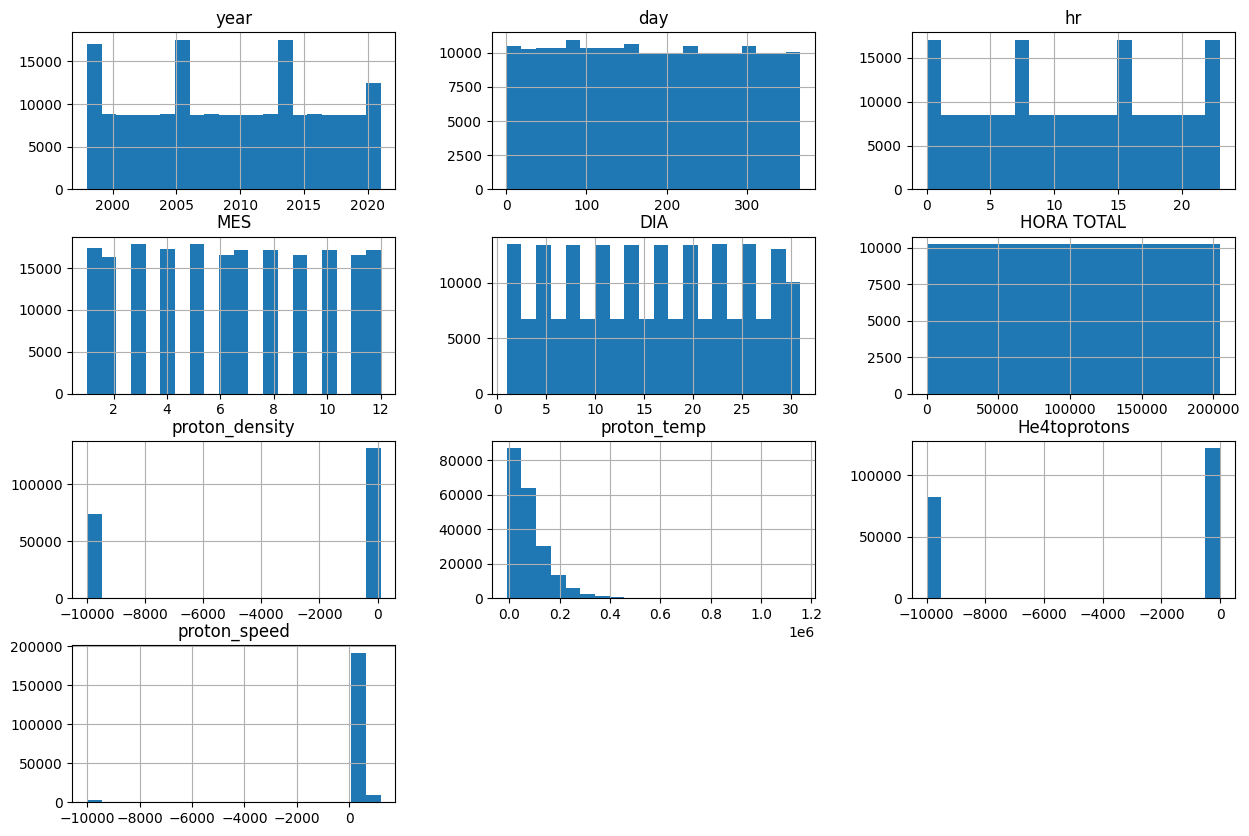

In [ ]:
# Seleccionar columnas numéricas
columnas_numericas = df_sol.select_dtypes(include='number')

# Histograma para columnas numéricas
columnas_numericas.hist(bins=20, figsize=(15, 10))
plt.show()

Comprobamos que las variables tengan sentido.

Empezando por *year*, tiene sentido que el último año y el primero tengan significativamente menos registros. 8760 son las horas que tiene un año aproximadamente.

In [ ]:
anys = sorted(list(set(df_sol["year"])))
cantidad = []

for a in anys:

  cantidad.append(len(df_sol[df_sol["year"]==a]))

print(cantidad)

[8232, 8760, 8784, 8760, 8760, 8760, 8784, 8760, 8760, 8760, 8784, 8760, 8760, 8760, 8784, 8760, 8760, 8760, 8784, 8760, 8760, 8760, 8784, 3672]


Comprobamos la cantidad de repeticiones/apariciones que tiene un determinado día del mes (del 1 al 31)

In [ ]:
dias = sorted(list(set(df_sol["DIA"])))
cantidad = []

for a in dias:

  cantidad.append(len(df_sol[df_sol["DIA"]==a]))

print(cantidad)

[6744, 6744, 6720, 6720, 6720, 6720, 6720, 6720, 6720, 6720, 6720, 6720, 6720, 6720, 6720, 6720, 6720, 6720, 6720, 6720, 6720, 6720, 6744, 6744, 6744, 6744, 6744, 6744, 6312, 6168, 3936]


**Vamos a tratar los NaNs**

Convertimos los outliers en NaN. Haciendo una inspección rápida hemos visto que típicamente estos valores son -9999 en las variables numéricas.

**Hay 73450 NaNs en la densidad de protones**

In [ ]:
proton_density_nans = sorted(list(set(df_sol["proton_density"][df_sol["proton_density"]<-500])))
cantidad = []

for a in proton_density_nans:

  cantidad.append(len(df_sol[df_sol["proton_density"]==a]))

print(cantidad)

[73450]


**Hay 2831 NaNs en la velocidad de los protones**

In [ ]:
proton_speed_nans = sorted(list(set(df_sol["proton_speed"][df_sol["proton_speed"]<-500])))
cantidad = []

for a in proton_speed_nans:

  cantidad.append(len(df_sol[df_sol["proton_speed"]==a]))

print(cantidad)

[2831]


**Hay 27751 NaNs en la Temperatura de los protones**

In [ ]:
proton_temp_nans = sorted(list(set(df_sol["proton_temp"][df_sol["proton_temp"]<-500])))
cantidad = []

for a in proton_temp_nans:

  cantidad.append(len(df_sol[df_sol["proton_temp"]==a]))

print(cantidad)

[27751]


**Hay 82711 NaNs en la variable del Helio**

In [ ]:
proton_he_nans = sorted(list(set(df_sol["He4toprotons"][df_sol["He4toprotons"]<-500])))
cantidad = []

for a in proton_he_nans:

  cantidad.append(len(df_sol[df_sol["He4toprotons"]==a]))

print(cantidad)

[82711]


Son bastantes NaNs considerando que la longitud del dataframe solar es de unos 200000 registros, por lo que tendremos que tratar posteriormente una estrategia adecuada para la imputación de los NaNs

In [ ]:
len(df_sol)

204768

A continuación, convertimos los outliers en NaN.

In [ ]:
# Lista de columnas a modificar
columnas_a_modificar = ['proton_speed', 'proton_density', 'proton_temp', 'He4toprotons']

# Reemplazar valores menores a -500 con NaN
df_sol[columnas_a_modificar] = df_sol[columnas_a_modificar].mask(df_sol[columnas_a_modificar] < -500, np.nan)


In [ ]:
df_sol.head(5000)

,year,day,hr,MES,DIA,FECHA,HORA TOTAL,proton_density,proton_temp,He4toprotons,proton_speed
0,1998,23,0,1,23,1998-01-23,1,NaN,NaN,NaN,NaN
1,1998,23,1,1,23,1998-01-23,2,NaN,NaN,NaN,NaN
2,1998,23,2,1,23,1998-01-23,3,NaN,NaN,NaN,NaN
3,1998,23,3,1,23,1998-01-23,4,NaN,NaN,NaN,NaN
4,1998,23,4,1,23,1998-01-23,5,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
4995,1998,231,3,8,19,1998-08-19,4996,3.981,71065.0,0.0061,331.17
4996,1998,231,4,8,19,1998-08-19,4997,3.261,76562.0,NaN,335.35
4997,1998,231,5,8,19,1998-08-19,4998,3.033,65435.0,NaN,330.89
4998,1998,231,6,8,19,1998-08-19,4999,NaN,NaN,NaN,319.38


**IMPUTACIÓN NANS**

Consideraremos una imputación mediante una interpolación lineal con splites a fin de "amortiguar" los valores entre cada gap de NaNs. La decisión de tomar una interpolación lineal en vez de cuadrática o cúbica se debe a que con estas dos últimas opciones las variables llegan a tomar valores negativos, por lo que carecería de sentido físico su tratamiento.

In [ ]:
def procesar_sol(df):

  # Imputar NaNs con spline de orden 1

  # Columnas que deseas imputar
  columnas_a_imputar = ['proton_speed', 'proton_density', 'proton_temp', 'He4toprotons']

  # Encuentra y aplica interpolación lineal para cada columna
  for columna in columnas_a_imputar:
      nan_indices = df[columna].isnull()
      not_nan_indices = ~nan_indices
      x = np.arange(len(df[columna]))

      # Crea una función de interpolación lineal
      lineal_interpolador = interp1d(x[not_nan_indices], df[columna][not_nan_indices], kind='linear', fill_value='extrapolate')

      # Interpola los valores NaN utilizando la función de interpolación lineal
      df[columna][nan_indices] = lineal_interpolador(x[nan_indices])

  return df

In [ ]:
df_sol_2 = procesar_sol(df_sol)

<ipython-input-21-dca8e28e4bd8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# Reajustamos el valor de HORA TOTAL para que coincida con el del dataset de los terremotos
df_sol_2["HORA TOTAL"] = df_sol_2["HORA TOTAL"] - 1

In [ ]:
df_sol_2.head(5000)

,year,day,hr,MES,DIA,FECHA,HORA TOTAL,proton_density,proton_temp,He4toprotons,proton_speed
0,1998,23,0,1,23,1998-01-23,0,-494.08900,330233.900000,0.6055,639.02
1,1998,23,1,1,23,1998-01-23,1,-492.45200,329206.000000,0.6036,638.01
2,1998,23,2,1,23,1998-01-23,2,-490.81500,328178.100000,0.6017,637.00
3,1998,23,3,1,23,1998-01-23,3,-489.17800,327150.200000,0.5998,635.99
4,1998,23,4,1,23,1998-01-23,4,-487.54100,326122.300000,0.5979,634.98
...,...,...,...,...,...,...,...,...,...,...,...
4995,1998,231,3,8,19,1998-08-19,4995,3.98100,71065.000000,0.0061,331.17
4996,1998,231,4,8,19,1998-08-19,4996,3.26100,76562.000000,0.0070,335.35
4997,1998,231,5,8,19,1998-08-19,4997,3.03300,65435.000000,0.0079,330.89
4998,1998,231,6,8,19,1998-08-19,4998,3.82025,64393.083333,0.0088,319.38


In [ ]:
df_sol_2.to_excel(path+'/dataframes_preprocesados/data_sol_2_nans.xlsx', index=False)

# GRAFICAR MÉTRICAS SOLARES

No vamos a hacer uso de esto, solo se pondrá a modo de curiosidad.

Graficamos el comportamiento de las variables solares, aunque no lo usaremos para nuestras suposiciones.

In [ ]:
# Ruta de la carpeta actual en Google Drive
path = '/content/drive/My Drive/Master ciencia de datos (Big Data & TFM)/TFM - tormentas solares/bases de datos - nuevo'

# Ruta al archivo CSV en Google Drive
file_path = path + '/dataframes_preprocesados/data_sol_2_nans.xlsx'

# Leer la segunda hoja del archivo Excel
df_sol = pd.read_excel(file_path, sheet_name=0)

In [ ]:
df_sol.head()

,year,day,hr,MES,DIA,FECHA,HORA TOTAL,proton_density,proton_temp,He4toprotons,proton_speed
0,1998,23,0,1,23,1998-01-23,0,-494.089,330233.9,0.6055,639.02
1,1998,23,1,1,23,1998-01-23,1,-492.452,329206.0,0.6036,638.01
2,1998,23,2,1,23,1998-01-23,2,-490.815,328178.1,0.6017,637.00
3,1998,23,3,1,23,1998-01-23,3,-489.178,327150.2,0.5998,635.99
4,1998,23,4,1,23,1998-01-23,4,-487.541,326122.3,0.5979,634.98


In [ ]:
descripcion = df_sol.describe(include='all')
print(descripcion)

                 year            day             hr            MES  \
count   204768.000000  204768.000000  204768.000000  204768.000000   
unique            NaN            NaN            NaN            NaN   
top               NaN            NaN            NaN            NaN   
freq              NaN            NaN            NaN            NaN   
mean      2009.244257     181.670066      11.500000       6.474801   
std          6.748173     105.385458       6.922203       3.447348   
min       1998.000000       1.000000       0.000000       1.000000   
25%       2003.000000      90.000000       5.750000       3.000000   
50%       2009.000000     180.000000      11.500000       6.000000   
75%       2015.000000     273.000000      17.250000       9.000000   
max       2021.000000     366.000000      23.000000      12.000000   

                  DIA       FECHA     HORA TOTAL  proton_density  \
count   204768.000000      204768  204768.000000   204768.000000   
unique            NaN  

In [ ]:
# Lista de columnas a graficar
columnas_a_graficar = ['proton_speed', 'proton_density', 'proton_temp', 'He4toprotons']

# Lista de columnas a graficar
columnas_a_graficar = ['proton_speed', 'proton_density', 'proton_temp', 'He4toprotons']

# Crear un gráfico interactivo para cada columna
for columna in columnas_a_graficar:
    fig = px.line(df_sol.dropna(subset=[columna]), x='HORA TOTAL', y=columna, title=f'Serie Temporal de {columna}')
    fig.update_xaxes(title_text='HORA TOTAL')
    fig.update_yaxes(title_text=columna)
    fig.show()

Output hidden; open in https://colab.research.google.com to view.

Mostramos una matriz de correlación para ver el comportamiento entre las distintas variables.

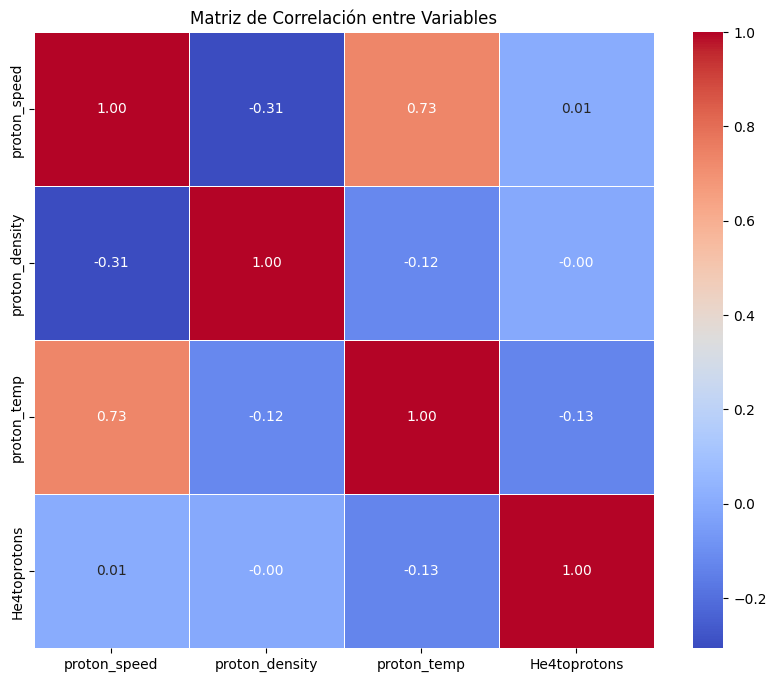

In [ ]:
# Seleccionamos las columnas de interés para el cálculo de la matriz de correlación
columnas_a_calcular_corr = ['proton_speed', 'proton_density', 'proton_temp', 'He4toprotons']

# Crear un DataFrame con las columnas seleccionadas
df_corr = df_sol[columnas_a_calcular_corr]

# Calcular la matriz de correlación
matriz_correlacion = df_corr.corr()

# Crear un mapa de calor (heatmap) para visualizar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Matriz de Correlación entre Variables")
plt.show()

# UNIÓN DE DATAFRAMES Y FILTRADO

Finalmente nos disponemos a unir el dataframe solar y el de los terremotos sabiendo que la columna *hora_total* de los terremotos y *HORA TOTAL* del sol deben coincidir. Agruparemos la cantidad de terremotos que hay en una hora determinada en una nueva variable a la que llamaremos *cantidad*.

In [ ]:
# Ruta de la carpeta actual en Google Drive
path = '/content/drive/My Drive/Master ciencia de datos (Big Data & TFM)/TFM - tormentas solares/bases de datos - nuevo'

# Ruta al archivo CSV en Google Drive
file_path_sol = path + '/dataframes_preprocesados/data_sol_2_nans.xlsx'

# Leer la segunda hoja del archivo Excel
df_sol = pd.read_excel(file_path_sol, sheet_name=0)

In [ ]:
# Ruta de la carpeta actual en Google Drive
path = '/content/drive/My Drive/Master ciencia de datos (Big Data & TFM)/TFM - tormentas solares/bases de datos - nuevo'

# Ruta al archivo CSV en Google Drive
file_path_terremotos = path + '/dataframes_preprocesados/terremotos_tectonicos_7_grados.xlsx'   # Terremotos NO tectonicos a 7 grados de separación. Escogemos este por defecto.

# Carga los datos en un DataFrame
df_quake = pd.read_excel(file_path_terremotos)

# Escogemos los terremotos anteriores al 3 de junio de 2021 porque no tenemos tantos datos del sol
df_quake = df_quake[df_quake["time.1"]<"2021-06-03"]

In [ ]:
# Muestra las filas de TERREMOTOS
df_quake[["time.1", "dia_anual", "hora", "hora_total", "latitude", "longitude", "depth", "mag_common", "cluster", "cantidad_cluster", "cantidad_diaria"]]

,time.1,dia_anual,hora,hora_total,latitude,longitude,depth,mag_common,cluster,cantidad_cluster,cantidad_diaria
0,1998-01-23,23,6,6,19.418667,-155.273167,9.743,4.8090,1,74,56
1,1998-01-24,24,20,44,46.700000,-1.400000,2.000,3.9700,-1,1,51
2,1998-01-27,27,3,99,19.201167,-155.696833,4.860,4.7420,-1,1,59
3,1998-01-27,27,9,105,50.500000,1.200000,2.000,4.4700,-1,1,59
4,1998-01-27,27,18,114,51.152000,15.935000,5.000,4.3700,-1,1,59
...,...,...,...,...,...,...,...,...,...,...,...
17520,2021-06-02,153,6,204750,18.867833,-155.235833,9.890,4.6817,42605,3,63
17521,2021-06-02,153,6,204750,44.681333,-110.006000,14.970,3.3400,-1,1,63
17522,2021-06-02,153,13,204757,10.902600,-12.592300,10.000,5.3360,-1,1,63
17523,2021-06-02,153,15,204759,19.172000,-155.251833,46.430,4.7487,-1,1,63


In [ ]:
def fusion_datasets(datasun, dataquake, filtro_mag='mayor', mag=11, filtro_dep='mayor', dep=-100, lags=120, unique_lag=False, graficar=False, grado=0, bol=True):
  '''
  Descripción: Esta función está diseñada para coger el dataframe solar "datasun" y unirlo con el de terremotos "dataquake".
  El dataframe resultante df_fusion consistirá en un montón de registros desde el 4/02/1998 hasta el 27/05/2021 en el que
  cada registro representa una hora desde la fecha inicial hasta la final, por lo que consta de 204799 registros.
  En cada uno de ellos, tendremos información de las 4 variables solares (velocidad, densidad, temperatura, helio) y la
  cantidad de terremotos registrados en esa misma hora dados unos filtros iniciales impuestos en esta misma función.

  - filtro_mag: para filtrar el dataquake según la magnitud de los terremotos. Los valores admitidos son mayor, igual, menor, aprox.
  - mag: magnitud de los terremotos para filtrarlos según el criterio de filtro_mag
  - dep: profundidad en km del terremoto. Si es negativa implica que el terremoto ocurre sobre el nivel del mar (montañas, corteza).
  - filtro_dep: para filtrar el dataquake según la profundidad de los terremotos. Los valores admitidos son mayor, igual, menor, aprox.
  - lags: esto nos creará tantas columnas n como sea el valor de lags, indicando en cada una de ellas la cantidad de terremotos
          que hay pasadas n, n-1, n-2, ... 1 horas en el futuro. Básicamente corre la columna 'cantidad' hacia arriba y guarda
          el resultado en columna_lag_n, columna_lag_n-1, ... columna_lag_1.
  - unique_lag: si es True, el dataframe final df_fusion contendrá solamente la columna_lag que se haya indicado en lag. Esto es
                útil si solamente nos interesa estudiar la variable cantidad en una hora concreta sin necesidad de hacer tantas columnas.
  - graficar: True, False. Si es False, no se graficará la matriz de correlación de las variables solares respecto a la cantidad
              de terremotos en esa misma hora, ni respecto a la cantidad_lag_n con más correlación hallada.
  - grado: Indica a partir de cuántos grados excluiremos los terremotos respecto a los bordes tectónicos.
  - bol: True, False. Si es True, los valores de las columnas cantidad, cantidad_lag_n, etc. se considerarán binarias (1 - existencia
          de terremoto. 0 - no hay terremoto)
  '''

  def procesar_fusion(df):

    # Renombramos los campos solares
    df = df.rename(columns={
        'proton_density': 'densidad',
        'proton_temp': 'temperatura',
        'proton_speed': 'velocidad',
        'He4toprotons': 'helio'
        })

    # Acotamos por la fecha porque los primeros 300 registros son nans inicialmente
    df = df[df['FECHA'] > '1998-02-04']
    # Acotamos por la fecha porque los últimos 2 días son nans inicialmente (más los 2 de insertar lags)
    df = df[df['FECHA'] < '2021-05-27']

    return df

  ############################################################################################################
  ##  Importamos Dataquake con x grados de separacion a los bordes tectonicos en caso de ser diferente a 0  ##
  ############################################################################################################

  if grado != 0:

    # Ruta de la carpeta actual en Google Drive
    path = '/content/drive/My Drive/Master ciencia de datos (Big Data & TFM)/TFM - tormentas solares/bases de datos - nuevo'

    # Ruta al archivo CSV en Google Drive
    file_path_terremotos = path + f'/dataframes_preprocesados/terremotos_tectonicos_{grado}_grados.xlsx'   # Terremotos NO tectonicos

    # Carga los datos en un DataFrame
    dataquake = pd.read_excel(file_path_terremotos)

    # Escogemos los terremotos anteriores al 3 de junio de 2021
    dataquake = dataquake[dataquake["time.1"]<"2021-06-03"]


  ###############################################
  #  Condiciones de filtrado según profundidad  #
  ###############################################

  if (dep > -100):
    if filtro_dep == 'mayor':
      dataquake = dataquake[dataquake["depth"]>dep]
    elif filtro_dep == 'igual':
      dataquake = dataquake[dataquake["depth"]==dep]
    elif filtro_dep == 'menor':
      dataquake = dataquake[dataquake["depth"]<dep]
    elif filtro_dep == 'aprox':
      dataquake = dataquake[ (dataquake["depth"]<dep+3) & (dataquake["depth"]>=dep-3)]
    else:
      filtro_dep = 'mayor'
  else:
    pass


  ############################################
  #  Condiciones de filtrado según magnitud  #
  ############################################

  if (mag < 10 and mag >= 0):
    if filtro_mag == 'mayor':
      dataquake = dataquake[dataquake["mag_common"]>mag]
    elif filtro_mag == 'igual':
      dataquake = dataquake[dataquake["mag_common"]==mag]
    elif filtro_mag == 'menor':
      dataquake = dataquake[dataquake["mag_common"]<mag]
    elif filtro_mag == 'aprox':
      dataquake = dataquake[ (dataquake["mag_common"]<mag+0.5) & (dataquake["mag_common"]>mag-0.5)]
    else:
      filtro_mag = 'mayor'
  else:
    pass

  # Utilizar groupby y size para contar la cantidad de registros
  df_cantidad = dataquake.groupby('hora_total').size().reset_index(name='cantidad')


  ###########################
  #  Fusionamos dataframes  #
  ###########################

  # Obtener el rango completo de valores de "hora_total" desde el mínimo hasta el máximo
  rango_completo = pd.DataFrame({'hora_total': range(datasun['HORA TOTAL'].min(), datasun['HORA TOTAL'].max() + 1)})

  # Fusionar el rango completo con df_cantidad
  df_completo = pd.merge(rango_completo, df_cantidad, on='hora_total', how='left')

  # Llenar los valores faltantes de "cantidad" con ceros
  df_completo['cantidad'] = df_completo['cantidad'].fillna(0).astype(int)

  # Realizar la fusión de datasun y df_completo
  df_fusion = pd.merge(datasun, df_completo, left_on='HORA TOTAL', right_on='hora_total', how='left')

  # Eliminar la columna redundante "HORA TOTAL" y otras que no necesitamos
  columns_to_drop = ['HORA TOTAL', 'year', 'MES', 'DIA', 'day']
  df_fusion = df_fusion.drop(columns=columns_to_drop, axis=1)


  ##############################################
  ########  COVARIANZA   MÁXIMA           ######
  ##############################################

  # Definir el número de lags que deseas introducir. Por defecto 168h que es una semana
  num_lags = lags
  dicc_lag = {}
  dicc_lag[f'cantidad'] = 0
  warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

  # Introducir lags en 'cantidad'
  for i in range(1, num_lags + 1):                                          ##################################################
      df_fusion[f'cantidad_lag_{i}'] = df_fusion['cantidad'].shift(-i)      # Para correr los datos hacia atrás en el tiempo #
      dicc_lag[f'cantidad_lag_{i}'] = i                                     ##################################################

  cantidades_columnas = df_fusion.columns[11:].tolist()

  # Seleccionar las columnas de interés para el cálculo de la matriz de correlación
  columnas_a_calcular_corr = ['proton_speed', 'proton_density', 'proton_temp']

  for col in cantidades_columnas:
    columnas_a_calcular_corr.append(col)

  # Crear un DataFrame con las columnas seleccionadas
  df_corr = df_fusion[columnas_a_calcular_corr]

  # Calcular la matriz de correlación
  matriz_correlacion = df_corr.corr()

  suma_cuadratica = []

  for cant in cantidades_columnas:

    # Suma cuatratica de la cov de (cantidad_x VS velocidad) + (cantidad_x VS densidad)
    suma_cuadratica.append( np.sqrt( matriz_correlacion[cant][0]**2 + matriz_correlacion[cant][1]**2 ) )

  # Cogemos el máximo de suma_cuadratica y su posicion, la cual nos dirá cuántas horas hemos desplazado
  maximo = max(suma_cuadratica)
  horas_corridas = suma_cuadratica.index(maximo)

  if horas_corridas != 0:

    # Creamos el dataframe final fusionado con la columna de covarianza según la hora lageada con mayor covarianza
    df_fusion_final = df_fusion[['FECHA', 'hora_total', 'proton_density',	'proton_temp',	'He4toprotons',	'proton_speed', 'cantidad', f'cantidad_lag_{horas_corridas}']]

    # Seleccionar las columnas de interés para el cálculo de la matriz de correlación
    columnas_a_calcular_corr_final = ['proton_speed', 'proton_density', 'proton_temp', 'cantidad', f'cantidad_lag_{horas_corridas}']

  else:

    df_fusion_final = df_fusion[['FECHA', 'hora_total', 'proton_density',	'proton_temp',	'He4toprotons',	'proton_speed', 'cantidad']]
    columnas_a_calcular_corr_final = ['proton_speed', 'proton_density', 'proton_temp', 'cantidad']

  # Crear un DataFrame con las columnas seleccionadas
  df_corr_2 = df_fusion[columnas_a_calcular_corr_final]

  # Calcular la matriz de correlación
  matriz_correlacion_2 = df_corr_2.corr()

  print(f'La hora lagueada máxima es {horas_corridas}')

  if graficar == True:
    # Crear un mapa de calor (heatmap) para visualizar la matriz de correlación
    plt.figure(figsize=(10, 8))
    sns.heatmap(matriz_correlacion_2, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title("Matriz de Correlación entre Variables")
    plt.show()


  ##################################################
  ###  Nos quedamos únicamente con una columna lag #
  ##################################################

  if unique_lag == True:

    df_fusion = df_fusion[ ['FECHA', 'hora_total', 'proton_density',	'proton_temp',	'He4toprotons',	'proton_speed', 'cantidad', f'cantidad_lag_{lags}'] ]


  ##############################################
  ###  Transformamos a booleanos la cantidad ###
  ##############################################

  if bol == True:

    # Encuentra la posición de la columna 'cantidad'
    indice_cantidad = df_fusion.columns.get_loc('cantidad')

    # Selecciona las columnas a la derecha de 'cantidad'
    columnas_a_transformar = df_fusion.columns[indice_cantidad:]

    # Aplica la condición a las columnas seleccionadas
    df_fusion[columnas_a_transformar] = df_fusion[columnas_a_transformar] > 0


  #########################################
  #  Dejamos Bonito el dataset df_fusion  #
  #########################################

  df_fusion = procesar_fusion(df_fusion)

  return df_fusion

La hora lagueada máxima es 0


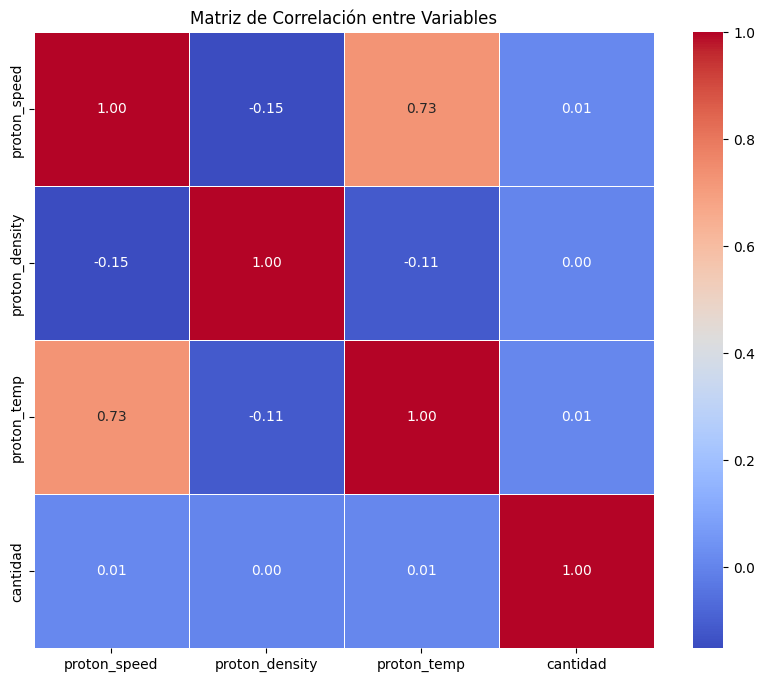

In [ ]:
# Cogemos con 7º de separacion por defecto

df_fusion = fusion_datasets(df_sol, df_quake, mag=0, lags=168, graficar=True)

In [ ]:
df_fusion[['hora_total', 'FECHA', 'densidad', 'temperatura', 'helio', 'velocidad', 'cantidad']].head()

,hora_total,FECHA,densidad,temperatura,helio,velocidad,cantidad
312,312,1998-02-05,16.655,9529.1,0.0127,323.90,False
313,313,1998-02-05,20.601,8757.7,0.0141,322.89,False
314,314,1998-02-05,18.679,9559.4,0.0087,324.61,False
315,315,1998-02-05,18.481,8965.9,0.0051,322.68,False
316,316,1998-02-05,28.315,8329.0,0.0061,321.84,False


In [ ]:
df_fusion.describe()[["velocidad", "densidad", "temperatura", "helio"]]

,velocidad,densidad,temperatura,helio
count,204288.000000,204288.000000,2.042880e+05,204288.000000
mean,428.442198,6.224059,8.606477e+04,0.029098
std,100.984710,4.942090,7.195239e+04,0.020245
min,227.540000,0.061000,2.275500e+03,0.000400
25%,355.070000,3.158487,3.760062e+04,0.015208
50%,406.460000,4.869876,6.389950e+04,0.025800
75%,481.232500,7.675712,1.124100e+05,0.038054
max,1187.890000,104.335000,1.156600e+06,0.345400




---



---



---



In [ ]:
# Guardamos data de sol + terremotos con 7º de separacion respecto bordes tectonicos
df_fusion.to_excel(path+'/dataframes_preprocesados/data_fusion.xlsx', index=False)



---

---



---





---



# Creación varios dataframes a distintos ángulos

In [ ]:
# Ruta de la carpeta actual en Google Drive
path = '/content/drive/My Drive/Master ciencia de datos (Big Data & TFM)/TFM - tormentas solares/bases de datos - nuevo'

# Ruta al archivo CSV en Google Drive
file_path_sol = path + '/dataframes_preprocesados/data_sol_2_nans.xlsx'

# Leer la segunda hoja del archivo Excel
df_sol = pd.read_excel(file_path_sol, sheet_name=0)

In [ ]:
# Ruta de la carpeta actual en Google Drive
path = '/content/drive/My Drive/Master ciencia de datos (Big Data & TFM)/TFM - tormentas solares/bases de datos - nuevo'

# Ruta al archivo CSV en Google Drive
file_path_terremotos = path + '/dataframes_preprocesados/terremotos_tectonicos_7_grados.xlsx'   # Terremotos NO tectonicos (por defecto coge uno para pasarlo a la funcion aunque no lo usemos)

# Carga los datos en un DataFrame
df_quake = pd.read_excel(file_path_terremotos)

# Escogemos los terremotos anteriores al 3 de junio de 2021
df_quake = df_quake[df_quake["time.1"]<"2021-06-03"]



---



---



---



In [ ]:
df_fusion_1_grado = fusion_datasets(df_sol, df_quake, mag=-1, grado=1)

# Guardamos data de sol + terremotos con 7º de separacion respecto bordes tectonicos
df_fusion_1_grado.to_excel(path+'/dataframes_preprocesados/data_fusion_1_grado.xlsx', index=False)

La hora lagueada máxima es 108




---



---



---



In [ ]:
df_fusion_2_grado = fusion_datasets(df_sol, df_quake, mag=-1, grado=2)

# Guardamos data de sol + terremotos con 7º de separacion respecto bordes tectonicos
df_fusion_2_grado.to_excel(path+'/dataframes_preprocesados/data_fusion_2_grado.xlsx', index=False)

La hora lagueada máxima es 4




---



---



---



In [ ]:
df_fusion_3_grado = fusion_datasets(df_sol, df_quake, mag=-1, grado=3)

# Guardamos data de sol + terremotos con 7º de separacion respecto bordes tectonicos
df_fusion_3_grado.to_excel(path+'/dataframes_preprocesados/data_fusion_3_grado.xlsx', index=False)

La hora lagueada máxima es 12



---



---



---



In [ ]:
df_fusion_4_grado = fusion_datasets(df_sol, df_quake, mag=-1, grado=4)

# Guardamos data de sol + terremotos con 7º de separacion respecto bordes tectonicos
df_fusion_4_grado.to_excel(path+'/dataframes_preprocesados/data_fusion_4_grado.xlsx', index=False)

La hora lagueada máxima es 10




---



---



---



In [ ]:
df_fusion_5_grado = fusion_datasets(df_sol, df_quake, mag=-1, grado=5)

# Guardamos data de sol + terremotos con 7º de separacion respecto bordes tectonicos
df_fusion_5_grado.to_excel(path+'/dataframes_preprocesados/data_fusion_5_grado.xlsx', index=False)

La hora lagueada máxima es 10




---



---



---



In [ ]:
df_fusion_6_grado = fusion_datasets(df_sol, df_quake, mag=-1, grado=6)

# Guardamos data de sol + terremotos con 7º de separacion respecto bordes tectonicos
df_fusion_6_grado.to_excel(path+'/dataframes_preprocesados/data_fusion_6_grado.xlsx', index=False)

La hora lagueada máxima es 4




---



---



---



In [ ]:
df_fusion_7_grado = fusion_datasets(df_sol, df_quake, mag=-1, grado=7)

# Guardamos data de sol + terremotos con 7º de separacion respecto bordes tectonicos
df_fusion_7_grado.to_excel(path+'/dataframes_preprocesados/data_fusion_7_grado.xlsx', index=False)



---



---



---



In [ ]:
df_fusion_8_grado = fusion_datasets(df_sol, df_quake, mag=-1, grado=8)

# Guardamos data de sol + terremotos con 7º de separacion respecto bordes tectonicos
df_fusion_8_grado.to_excel(path+'/dataframes_preprocesados/data_fusion_8_grado.xlsx', index=False)

La hora lagueada máxima es 10




---



---



---



In [ ]:
df_fusion_9_grado = fusion_datasets(df_sol, df_quake, mag=-1, grado=9)

# Guardamos data de sol + terremotos con 7º de separacion respecto bordes tectonicos
df_fusion_9_grado.to_excel(path+'/dataframes_preprocesados/data_fusion_9_grado.xlsx', index=False)

La hora lagueada máxima es 80




---



---



In [ ]:
df_fusion_10_grado = fusion_datasets(df_sol, df_quake, mag=-1, grado=10)

# Guardamos data de sol + terremotos con 7º de separacion respecto bordes tectonicos
df_fusion_10_grado.to_excel(path+'/dataframes_preprocesados/data_fusion_10_grado.xlsx', index=False)

La hora lagueada máxima es 81


In [ ]:
df_fusion_11_grado = fusion_datasets(df_sol, df_quake, mag=-1, grado=11)

# Guardamos data de sol + terremotos con 7º de separacion respecto bordes tectonicos
df_fusion_11_grado.to_excel(path+'/dataframes_preprocesados/data_fusion_11_grado.xlsx', index=False)

La hora lagueada máxima es 12


In [ ]:
df_fusion_12_grado = fusion_datasets(df_sol, df_quake, mag=-1, grado=12)

# Guardamos data de sol + terremotos con 7º de separacion respecto bordes tectonicos
df_fusion_12_grado.to_excel(path+'/dataframes_preprocesados/data_fusion_12_grado.xlsx', index=False)

La hora lagueada máxima es 10


In [ ]:
df_fusion_13_grado = fusion_datasets(df_sol, df_quake, mag=-1, grado=13)

# Guardamos data de sol + terremotos con 7º de separacion respecto bordes tectonicos
df_fusion_13_grado.to_excel(path+'/dataframes_preprocesados/data_fusion_13_grado.xlsx', index=False)

La hora lagueada máxima es 94


# Creación varios dataframes a distintos ángulos (mag < 5)

In [ ]:
# Ruta de la carpeta actual en Google Drive
path = '/content/drive/My Drive/Master ciencia de datos (Big Data & TFM)/TFM - tormentas solares/bases de datos - nuevo'

# Ruta al archivo CSV en Google Drive
file_path_sol = path + '/dataframes_preprocesados/data_sol_2_nans.xlsx'

# Leer la segunda hoja del archivo Excel
df_sol = pd.read_excel(file_path_sol, sheet_name=0)

In [ ]:
# Ruta de la carpeta actual en Google Drive
path = '/content/drive/My Drive/Master ciencia de datos (Big Data & TFM)/TFM - tormentas solares/bases de datos - nuevo'

# Ruta al archivo CSV en Google Drive
file_path_terremotos = path + '/dataframes_preprocesados/terremotos_tectonicos_7_grados.xlsx'   # Terremotos NO tectonicos (por defecto coge uno para pasarlo a la funcion aunque no lo usemos)

# Carga los datos en un DataFrame
df_quake = pd.read_excel(file_path_terremotos)

# Escogemos los terremotos anteriores al 3 de junio de 2021
df_quake = df_quake[df_quake["time.1"]<"2021-06-03"]



---



---



---



In [ ]:
df_fusion_1_grado = fusion_datasets(df_sol, df_quake, mag=5, filtro_mag='menor', grado=1)

# Guardamos data de sol + terremotos con 7º de separacion respecto bordes tectonicos
df_fusion_1_grado.to_excel(path+'/dataframes_preprocesados/data_fusion_1_grado_mag5_menor.xlsx', index=False)

La hora lagueada máxima es 89




---



---



---



In [ ]:
df_fusion_2_grado = fusion_datasets(df_sol, df_quake, mag=5, filtro_mag='menor', grado=2)

# Guardamos data de sol + terremotos con 7º de separacion respecto bordes tectonicos
df_fusion_2_grado.to_excel(path+'/dataframes_preprocesados/data_fusion_2_grado_mag5_menor.xlsx', index=False)

La hora lagueada máxima es 32




---



---



---



In [ ]:
df_fusion_3_grado = fusion_datasets(df_sol, df_quake, mag=5, filtro_mag='menor', grado=3)

# Guardamos data de sol + terremotos con 7º de separacion respecto bordes tectonicos
df_fusion_3_grado.to_excel(path+'/dataframes_preprocesados/data_fusion_3_grado_mag5_menor.xlsx', index=False)

La hora lagueada máxima es 31



---



---



---



In [ ]:
df_fusion_4_grado = fusion_datasets(df_sol, df_quake, mag=5, filtro_mag='menor', grado=4)

# Guardamos data de sol + terremotos con 7º de separacion respecto bordes tectonicos
df_fusion_4_grado.to_excel(path+'/dataframes_preprocesados/data_fusion_4_grado_mag5_menor.xlsx', index=False)

La hora lagueada máxima es 0




---



---



---



In [ ]:
df_fusion_5_grado = fusion_datasets(df_sol, df_quake, mag=5, filtro_mag='menor', grado=5)

# Guardamos data de sol + terremotos con 7º de separacion respecto bordes tectonicos
df_fusion_5_grado.to_excel(path+'/dataframes_preprocesados/data_fusion_5_grado_mag5_menor.xlsx', index=False)

La hora lagueada máxima es 9




---



---



---



In [ ]:
df_fusion_6_grado = fusion_datasets(df_sol, df_quake, mag=5, filtro_mag='menor', grado=6)

# Guardamos data de sol + terremotos con 7º de separacion respecto bordes tectonicos
df_fusion_6_grado.to_excel(path+'/dataframes_preprocesados/data_fusion_6_grado_mag5_menor.xlsx', index=False)

La hora lagueada máxima es 0




---



---



---



In [ ]:
df_fusion_7_grado = fusion_datasets(df_sol, df_quake, mag=5, filtro_mag='menor', grado=7)

# Guardamos data de sol + terremotos con 7º de separacion respecto bordes tectonicos
df_fusion_7_grado.to_excel(path+'/dataframes_preprocesados/data_fusion_7_grado_mag5_menor.xlsx', index=False)

La hora lagueada máxima es 0




---



---



---



In [ ]:
df_fusion_8_grado = fusion_datasets(df_sol, df_quake, mag=5, filtro_mag='menor', grado=8)

# Guardamos data de sol + terremotos con 7º de separacion respecto bordes tectonicos
df_fusion_8_grado.to_excel(path+'/dataframes_preprocesados/data_fusion_8_grado_mag5_menor.xlsx', index=False)

La hora lagueada máxima es 0




---



---



---



In [ ]:
df_fusion_9_grado = fusion_datasets(df_sol, df_quake, mag=5, filtro_mag='menor', grado=9)

# Guardamos data de sol + terremotos con 7º de separacion respecto bordes tectonicos
df_fusion_9_grado.to_excel(path+'/dataframes_preprocesados/data_fusion_9_grado_mag5_menor.xlsx', index=False)

La hora lagueada máxima es 5




---



---



In [ ]:
df_fusion_10_grado = fusion_datasets(df_sol, df_quake, mag=5, filtro_mag='menor', grado=10)

# Guardamos data de sol + terremotos con 7º de separacion respecto bordes tectonicos
df_fusion_10_grado.to_excel(path+'/dataframes_preprocesados/data_fusion_10_grado_mag5_menor.xlsx', index=False)

La hora lagueada máxima es 76


In [ ]:
df_fusion_11_grado = fusion_datasets(df_sol, df_quake, mag=5, filtro_mag='menor', grado=11)

# Guardamos data de sol + terremotos con 7º de separacion respecto bordes tectonicos
df_fusion_11_grado.to_excel(path+'/dataframes_preprocesados/data_fusion_11_grado_mag5_menor.xlsx', index=False)

La hora lagueada máxima es 8


In [ ]:
df_fusion_12_grado = fusion_datasets(df_sol, df_quake, mag=5, filtro_mag='menor', grado=12)

# Guardamos data de sol + terremotos con 7º de separacion respecto bordes tectonicos
df_fusion_12_grado.to_excel(path+'/dataframes_preprocesados/data_fusion_12_grado_mag5_menor.xlsx', index=False)

La hora lagueada máxima es 6


# Creación varios Dataframes según Magnitud

A estas alturas ya hemos ido al notebook 5_Modelo_Predictivo y hemos visto que el modelo logístico tiene mayor accuracy con los terremotos más allá de 1º respecto los bordes tectónicos cuando pasan 46h desde la detección de parámetros solares.

In [ ]:
df_mag_mayor_2 = fusion_datasets(df_sol, df_quake, filtro_mag='mayor', mag=2, lags=46, unique_lag=True, graficar=False, grado=1, bol=True)

df_mag_mayor_2.to_excel(path+'/dataframes_preprocesados/data_fusion_2_mag.xlsx', index=False)

La hora lagueada máxima es 0


In [ ]:
df_mag_mayor_3 = fusion_datasets(df_sol, df_quake, filtro_mag='mayor', mag=3, lags=46, unique_lag=True, graficar=False, grado=1, bol=True)

df_mag_mayor_3.to_excel(path+'/dataframes_preprocesados/data_fusion_3_mag.xlsx', index=False)

La hora lagueada máxima es 0


In [ ]:
df_mag_mayor_4 = fusion_datasets(df_sol, df_quake, filtro_mag='mayor', mag=4, lags=46, unique_lag=True, graficar=False, grado=1, bol=True)

df_mag_mayor_4.to_excel(path+'/dataframes_preprocesados/data_fusion_4_mag.xlsx', index=False)

La hora lagueada máxima es 1


In [ ]:
df_mag_mayor_5 = fusion_datasets(df_sol, df_quake, filtro_mag='mayor', mag=5, lags=46, unique_lag=True, graficar=False, grado=1, bol=True)

df_mag_mayor_5.to_excel(path+'/dataframes_preprocesados/data_fusion_5_mag.xlsx', index=False)

La hora lagueada máxima es 6


In [ ]:
df_mag_mayor_6 = fusion_datasets(df_sol, df_quake, filtro_mag='mayor', mag=6, lags=46, unique_lag=True, graficar=False, grado=1, bol=True)

df_mag_mayor_6.to_excel(path+'/dataframes_preprocesados/data_fusion_6_mag.xlsx', index=False)

La hora lagueada máxima es 42


In [ ]:
df_mag_mayor_7 = fusion_datasets(df_sol, df_quake, filtro_mag='mayor', mag=7, lags=46, unique_lag=True, graficar=False, grado=1, bol=True)

df_mag_mayor_7.to_excel(path+'/dataframes_preprocesados/data_fusion_7_mag.xlsx', index=False)

La hora lagueada máxima es 18


In [ ]:
df_mag_mayor_8 = fusion_datasets(df_sol, df_quake, filtro_mag='mayor', mag=8, lags=46, unique_lag=True, graficar=False, grado=1, bol=True)

df_mag_mayor_8.to_excel(path+'/dataframes_preprocesados/data_fusion_8_mag.xlsx', index=False)

La hora lagueada máxima es 42


# Creación varios Dataframes según Profundidad

In [ ]:
df_quake['depth'].describe()

count    17525.000000
mean        11.229302
std         15.832329
min         -3.340000
25%          5.000000
50%          8.432000
75%         11.680000
max        627.100000
Name: depth, dtype: float64

In [ ]:
df_dep_0 = fusion_datasets(df_sol, df_quake, filtro_dep = 'aprox', dep=-1, lags=46, unique_lag=True, graficar=False, grado=1, bol=True)

df_dep_0.to_excel(path+'/dataframes_preprocesados/data_fusion_0_dep.xlsx', index=False)

La hora lagueada máxima es 1


In [ ]:
df_dep_5 = fusion_datasets(df_sol, df_quake, filtro_dep = 'aprox', dep=5, lags=46, unique_lag=True, graficar=False, grado=1, bol=True)

df_dep_5.to_excel(path+'/dataframes_preprocesados/data_fusion_5_dep.xlsx', index=False)

La hora lagueada máxima es 5


In [ ]:
df_dep_11 = fusion_datasets(df_sol, df_quake, filtro_dep = 'aprox', dep=11, lags=46, unique_lag=True, graficar=False, grado=1, bol=True)

df_dep_11.to_excel(path+'/dataframes_preprocesados/data_fusion_11_dep.xlsx', index=False)

La hora lagueada máxima es 6


In [ ]:
df_dep_fondo = fusion_datasets(df_sol, df_quake, filtro_dep = 'mayor', dep=14, lags=46, unique_lag=True, graficar=False, grado=1, bol=True)

df_dep_fondo.to_excel(path+'/dataframes_preprocesados/data_fusion_Fondo_dep.xlsx', index=False)

La hora lagueada máxima es 31
